<a href="https://colab.research.google.com/github/sachin555-bst/Stock_Market_Analysis-Major_project-/blob/main/Sentiment_Analysis_Text_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install transformers

In [ ]:
# Libraries
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import time
import datetime
import random
import warnings
warnings.filterwarnings('ignore')

# Tokenize to add stopwords
from nltk import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords

# Data loading utility
from torch.utils.data import Dataset, TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split

# Models
from torch import nn
from transformers import BertModel, BertTokenizer, BertForSequenceClassification, AdamW, get_linear_schedule_with_warmup
from transformers import logging
logging.set_verbosity_error()

# Training
from torch import optim

# Evaluation
from sklearn.metrics import accuracy_score, matthews_corrcoef

%matplotlib inline

# specify GPU device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
import pandas as pd
import yfinance as yf
import datetime

# Downloading FTSE100 stocks data
ftse100_stocks = yf.download("SBIN.NS JIOFIN.NS AXS ADANIPORTS.NS  PANW", start=datetime.datetime(2019, 1, 1),
                             end=datetime.datetime(2024,3,12), group_by='tickers')

# Save DataFrame to a pickle file
ftse100_stocks.to_pickle('aqr_stocks.pkl')

[*********************100%%**********************]  5 of 5 completed


In [ ]:
article_sentiments = pd.read_pickle('aqr_stocks.pkl')
article_sentiments

Ticker       JIOFIN.NS                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2019-01-01         NaN         NaN         NaN         NaN         NaN   
2019-01-02         NaN         NaN         NaN         NaN         NaN   
2019-01-03         NaN         NaN         NaN         NaN         NaN   
2019-01-04         NaN         NaN         NaN         NaN         NaN   
2019-01-07         NaN         NaN         NaN         NaN         NaN   
...                ...         ...         ...         ...         ...   
2024-03-05  324.000000  327.899994  319.500000  321.700012  321.700012   
2024-03-06  322.950012  333.899994  321.350006  326.350006  326.350006   
2024-03-07  329.000000  337.399994  324.200012  333.899994  333.899994   
2024-03-08         NaN         NaN         NaN         NaN         NaN   
2024-03-11  336.899994  359.850006  332.450012  355.649994  355.649994   

Ticker                         PANW                                      ...  \
Price            Volume        Open        High         Low       Close  ...   
Date                                                                     ...   
2019-01-01          NaN         NaN         NaN         NaN         NaN  ...   
2019-01-02          NaN   61.680000   62.389999   60.639999   61.070000  ...   
2019-01-03          NaN   60.456669   60.959999   59.599998   59.900002  ...   
2019-01-04          NaN   60.686668   62.043331   60.540001   61.463333  ...   
2019-01-07          NaN   61.759998   62.666668   61.573334   62.450001  ...   
...                 ...         ...         ...         ...         ...  ...   
2024-03-05   18301430.0  295.890015  297.549988  284.679993  291.130005  ...   
2024-03-06   53717380.0  298.980011  300.000000  276.809998  278.859985  ...   
2024-03-07   35988720.0  280.000000  288.130005  277.750000  286.489990  ...   
2024-03-08          NaN  286.179993  288.450012  279.700012  280.200012  ...   
2024-03-11  121739300.0  278.299988  286.799988  277.609985  283.329987  ...   

Ticker            AXS                                  ADANIPORTS.NS  \
Price             Low      Close  Adj Close     Volume          Open   
Date                                                                   
2019-01-01        NaN        NaN        NaN        NaN    386.299988   
2019-01-02  50.650002  51.070000  43.700138   968700.0    388.000000   
2019-01-03  50.759998  50.950001  43.597450   844500.0    382.399994   
2019-01-04  51.410000  53.320000  45.625443  1003200.0    378.649994   
2019-01-07  52.709999  52.779999  45.163372   635500.0    385.000000   
...               ...        ...        ...        ...           ...   
2024-03-05  60.230000  60.709999  60.709999   570200.0   1344.050049   
2024-03-06  60.060001  60.680000  60.680000   669600.0   1342.699951   
2024-03-07  60.520000  60.939999  60.939999   435500.0   1329.800049   
2024-03-08  60.799999  61.180000  61.180000   432300.0           NaN   
2024-03-11  61.029999  61.480000  61.480000   520700.0   1331.000000   

Ticker                                                                     
Price              High          Low        Close    Adj Close     Volume  
Date                                                                       
2019-01-01   390.899994   384.049988   389.000000   376.710571  1233249.0  
2019-01-02   388.950012   378.000000   381.299988   369.253784  1506543.0  
2019-01-03   385.299988   376.600006   378.100006   366.154938  1902063.0  
2019-01-04   383.950012   375.850006   382.149994   370.076935  1669709.0  
2019-01-07   386.950012   379.350006   381.649994   369.592743  1260331.0  
...                 ...          ...          ...          ...        ...  
2024-03-05  1354.949951  1334.000000  1338.300049  1338.300049  1815438.0  
2024-03-06  1344.599976  1304.000000  1324.800049  1324.800049  2758443.0

In [ ]:
article_sentiments.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1347 entries, 2019-01-01 to 2024-03-11
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   (JIOFIN.NS, Open)           136 non-null    float64
 1   (JIOFIN.NS, High)           136 non-null    float64
 2   (JIOFIN.NS, Low)            136 non-null    float64
 3   (JIOFIN.NS, Close)          136 non-null    float64
 4   (JIOFIN.NS, Adj Close)      136 non-null    float64
 5   (JIOFIN.NS, Volume)         136 non-null    float64
 6   (PANW, Open)                1306 non-null   float64
 7   (PANW, High)                1306 non-null   float64
 8   (PANW, Low)                 1306 non-null   float64
 9   (PANW, Close)               1306 non-null   float64
 10  (PANW, Adj Close)           1306 non-null   float64
 11  (PANW, Volume)              1306 non-null   float64
 12  (SBIN.NS, Open)             1283 non-null   float64
 13  (SBIN.NS, High)

In [ ]:
!pip install pandas
import pandas as pd
article_sentiments = pd.DataFrame({'Label': [0, 1, 0, 1, 1]})

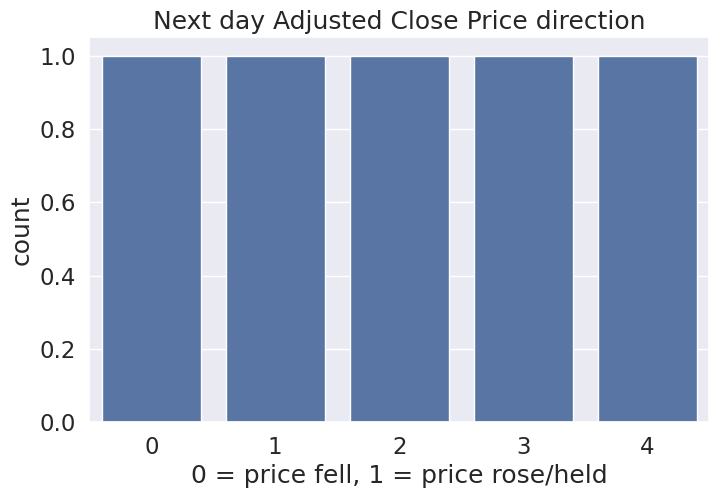

In [ ]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (8,5)
sns.countplot(article_sentiments.Label)
plt.title('Next day Adjusted Close Price direction')
plt.xlabel('0 = price fell, 1 = price rose/held');

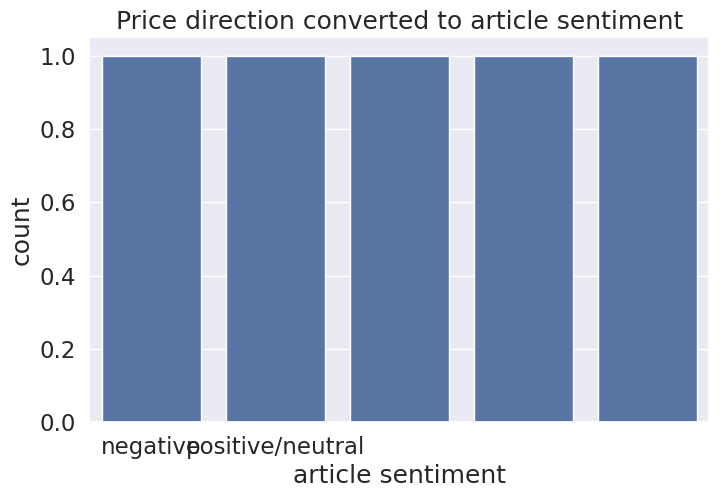

In [ ]:
# Plot showing Adjusted Close prices converted to sentiment

def to_sentiment(label):
  label = int(label)
  if label == 0:
    return 0
  else:
    return 1

article_sentiments['sentiment'] = article_sentiments.Label.apply(to_sentiment)

class_names = ['negative', 'positive/neutral']

# Plot the counts of observations in each categorical bin
ax = sns.countplot(article_sentiments.sentiment)

# Label the plot
plt.title('Price direction converted to article sentiment')
plt.xlabel('article sentiment')
ax.set_xticklabels(class_names);

In [ ]:
pip install nltk Googlenews newspaper3k wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.1/211.1 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.3/81.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.6/97.6 kB 13.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 48.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for tinysegmenter: filename=tinysegmenter-0.3-py3-none-any.whl size=13538 sha256=61ee429203c77c314a7d59af8f73d169bb2b777136b1aa5c1af6fb37a96f4e6d
  Stored in directory: /root/.cache/pip/wheels/c8/d6/6c/384f58df48c00b9a31d638005143b5b3ac62c3d25fb1447f23
  Created wheel for feedfinder2: filename=feedfinder2-0.0.4-py3-none-any.whl size=3340 sha256=02548cbfe9d1488d555cc1f109d0447091a4f1aa71d49685889ddc50715f99c9
  

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from GoogleNews import GoogleNews
from newspaper import Article
from newspaper import Config
from wordcloud import WordCloud, STOPWORDS

nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
now = dt.date.today()
now = now.strftime('%m-%d-%Y')
yesterday = dt.date.today() - dt.timedelta(days = 1)
yesterday = yesterday.strftime('%m-%d-%Y')

nltk.download('punkt')
user_agent = 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10.15; rv:78.0) Gecko/20100101 Firefox/78.0'
config = Config()
config.browser_user_agent = user_agent
config.request_timeout = 10


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
company_name = input("Please provide the name of the Company or a Ticker: ")
if company_name != '':
    print(f'Searching for and analyzing {company_name}, Please be patient, it might take a while...')
    googlenews = GoogleNews(start=yesterday,end=now)
    googlenews.search(company_name)
    result = googlenews.result()
    df = pd.DataFrame(result)
    print(df)


Please provide the name of the Company or a Ticker: TATAMOTORS
Searching for and analyzing TATAMOTORS, Please be patient, it might take a while...
                                               title                  media  \
0  Tata Motors Share Price Live blog for 16 Apr 2...                   mint   
1  TATA MOTORS Q4 2024 Results Date and Time: Div...                 ET Now   
2  Tata Motors share price Today Live Updates : T...                   mint   
3  Tata Nexon & Tata Punch Achieve Top Spots In I...       Mobility Outlook   
4  Ahead of Musk's India visit, Tata signs deal w...              TechStory   
5  Hot stocks on April 15: Tata Motors, IREDA, Ex...         BUSINESS TODAY   
6  BJP Manifesto Lok Sabha polls 2024: Tata Motor...                   mint   
7  Tata Motors Stocks Live Updates: Tata Motors S...     The Economic Times   
8  Shares of Tata Motors will go up to Rs 1250! D...          Connexionblog   
9  Brand new Tata Nexon DCA’s gearbox gives up — ...  The Finan

In [ ]:
try:
    list =[]
    for i in df.index:
        dict = {}
        article = Article(df['link'][i],config=config) #providing the link
        try:
          article.download()
          article.parse()
          article.nlp()
        except:
           pass
        dict['Date']=df['date'][i]
        dict['Media']=df['media'][i]
        dict['Title']=article.title
        dict['Article']=article.text
        dict['Summary']=article.summary
        dict['Key_words']=article.keywords
        list.append(dict)
    check_empty = not any(list)
    # print(check_empty)
    if check_empty == False:
      news_df=pd.DataFrame(list) #creating dataframe
      print(news_df)

except Exception as e:
    #exception handling
    print("exception occurred:" + str(e))
    print('Looks like, there is some error in retrieving the data, Please try again or try with a different ticker.' )


          Date                  Media  \
0  4 hours ago                   mint   
1  5 hours ago                 ET Now   
2  8 hours ago                   mint   
3  9 hours ago       Mobility Outlook   
4  9 hours ago              TechStory   
5  3 hours ago         BUSINESS TODAY   
6    1 day ago                   mint   
7    1 day ago     The Economic Times   
8   2 days ago          Connexionblog   
9   2 days ago  The Financial Express   

                                               Title  \
0                                                      
1  TATA MOTORS Q4 2024 Results Date and Time: Div...   
2                                                      
3                                                      
4                                                      
5  Hot stocks on April 15: Tata Motors, IREDA, Ex...   
6                                                      
7                                                      
8                                           

Positive Sentiment: 1.00
Neutral Sentiment: 8.00
Negative Sentiment: 1.00


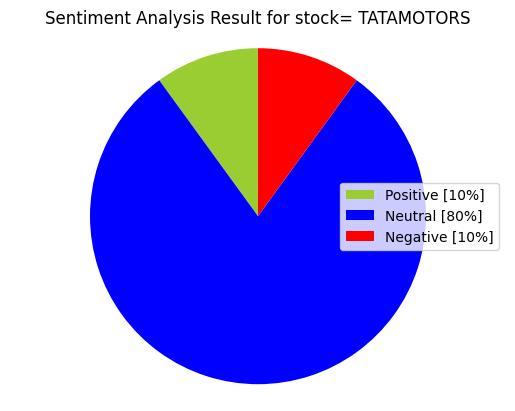

Wordcloud for TATAMOTORS


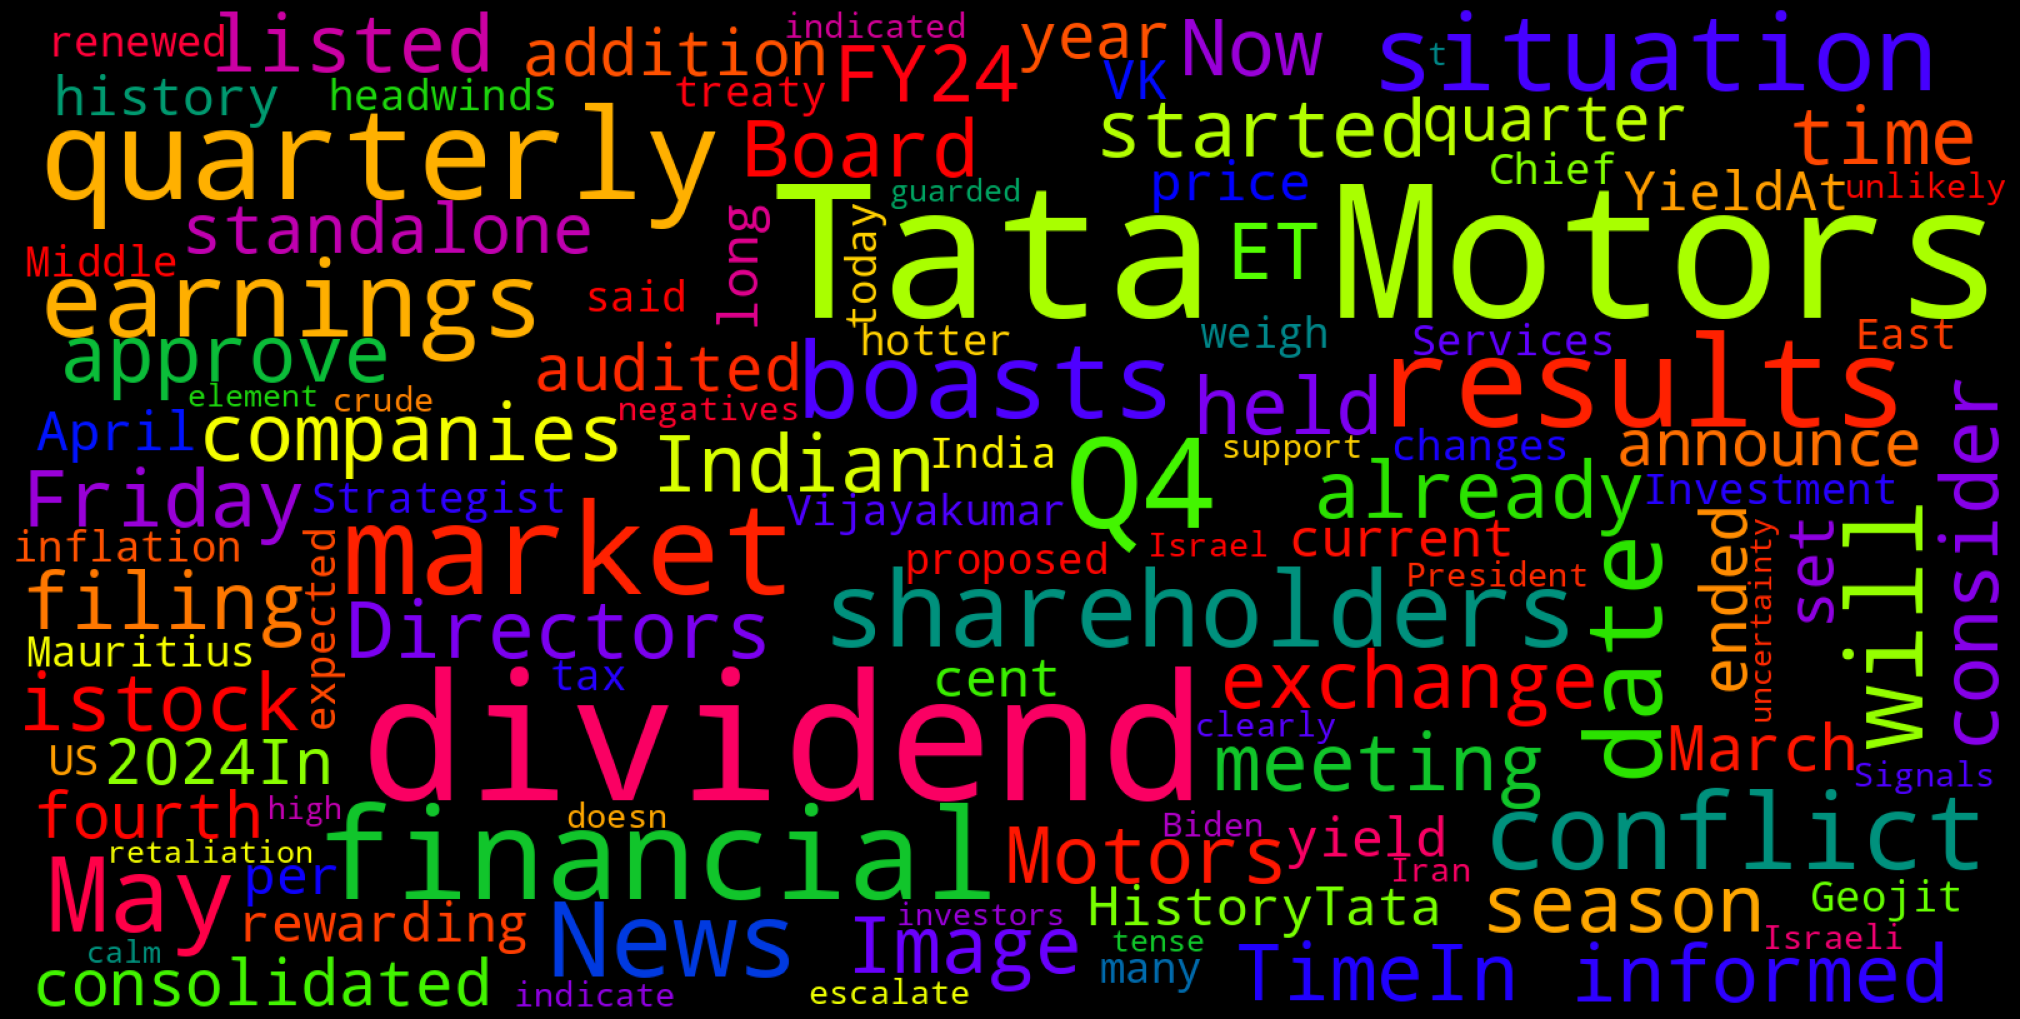

In [ ]:

def percentage(part,whole):
    return 100 * float(part)/float(whole)


positive = 0
negative = 0
neutral = 0

news_list = []
neutral_list = []
negative_list = []
positive_list = []


for news in news_df['Summary']:
    news_list.append(news)
    analyzer = SentimentIntensityAnalyzer().polarity_scores(news)
    neg = analyzer['neg']
    neu = analyzer['neu']
    pos = analyzer['pos']
    comp = analyzer['compound']

    if neg > pos:
        negative_list.append(news)
        negative += 1
    elif pos > neg:
        positive_list.append(news)
        positive += 1
    elif pos == neg:
        neutral_list.append(news)
        neutral += 1

positive = percentage(positive, len(news_df))
negative = percentage(negative, len(news_df))
neutral = percentage(neutral, len(news_df))


news_list = pd.DataFrame(news_list)
neutral_list = pd.DataFrame(neutral_list)
negative_list = pd.DataFrame(negative_list)
positive_list = pd.DataFrame(positive_list)

print("Positive Sentiment:", '%.2f' % len(positive_list), end='\n')
print("Neutral Sentiment:", '%.2f' % len(neutral_list), end='\n')
print("Negative Sentiment:", '%.2f' % len(negative_list), end='\n')

#Creating PieCart
labels = ['Positive ['+str(round(positive))+'%]' , 'Neutral ['+str(round(neutral))+'%]','Negative ['+str(round(negative))+'%]']
sizes = [positive, neutral, negative]
colors = ['yellowgreen', 'blue','red']
patches, texts = plt.pie(sizes,colors=colors, startangle=90)
plt.style.use('default')
plt.legend(labels)
plt.title("Sentiment Analysis Result for stock= "+company_name+"" )
plt.axis('equal')
plt.show()

# Word cloud visualization
def word_cloud(text):
    stopwords = set(STOPWORDS)
    allWords = ' '.join([nws for nws in text])
    wordCloud = WordCloud(background_color='black',width = 1600, height = 800,stopwords = stopwords,min_font_size = 20,max_font_size=150,colormap='prism').generate(allWords)
    fig, ax = plt.subplots(figsize=(20,10), facecolor='k')
    plt.imshow(wordCloud)
    ax.axis("off")
    fig.tight_layout(pad=0)
    plt.show()

print('Wordcloud for ' + company_name)
word_cloud(news_df['Summary'].values)
